In [2]:
from skimage.measure import label, regionprops
import numpy as np
import cv2
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import cv2
from skimage.measure import label, regionprops

def dilate_mask_using_orientation_aware_kernel(binary_mask: np.ndarray, kernel_size=(20, 20), num_dilations=8):
    labeled_mask = label(binary_mask)
    props = regionprops(labeled_mask)
    
    dilated_mask = np.zeros_like(binary_mask, dtype=np.uint8)

    for prop in props:
        if prop.area < 10:  # skip tiny regions
            continue

        angle_rad = -prop.orientation + np.pi / 2 # Account for the coordinate system
        eccentricity = prop.eccentricity  # [0, 1]

        # Adjust axes based on eccentricity (0 = circle, 1 = line)
        w, h = kernel_size
        major_axis = w // 2
        minor_axis = max(1, int((h // 2) * (1 - eccentricity)))  # small for elongated regions

        # Create unrotated elliptical kernel
        kernel = np.zeros((h, w), dtype=np.uint8)
        cv2.ellipse(
            img=kernel,
            center=(w // 2, h // 2),
            axes=(major_axis, minor_axis),
            angle=np.degrees(angle_rad),  # Directly input the ellipse angle
            startAngle=0,
            endAngle=360,
            color=1,
            thickness=-1
        )

        # Dilate the region using the custom kernel
        region_mask = (labeled_mask == prop.label).astype(np.uint8)
        dilated = region_mask.copy()
        for _ in range(num_dilations):
            dilated = cv2.dilate(dilated, kernel)

        # Merge into the global mask
        dilated_mask = np.maximum(dilated_mask, dilated)

    return dilated_mask > 0

def label_binary_mask(binary_mask: np.ndarray) -> np.ndarray:
    labeled_mask = label(binary_mask)
    return labeled_mask.astype(np.uint8)


def assign_labels_using_dilated_mask(binary_mask: np.ndarray, dilated_mask: np.ndarray):
    labeled_mask = label(binary_mask)
    props = regionprops(labeled_mask)

    for prop in props:

        region_mask = (labeled_mask == prop.label).astype(np.uint8)
        dilated_region = cv2.bitwise_and(dilated_mask, dilated_mask, mask=region_mask)

        if np.any(dilated_region):
            labeled_mask[region_mask > 0] = np.max(dilated_region) + 1

    return labeled_mask

def split_labeled_mask_to_binary_masks(labeled_mask: np.ndarray) -> list[np.ndarray]:
    """Split a labeled mask into a list of binary masks, one for each label (excluding background)."""
    masks = []
    for label_id in np.unique(labeled_mask):
        if label_id == 0:
            continue  # skip background
        binary_mask = (labeled_mask == label_id).astype(np.uint8)
        masks.append(binary_mask)
    return masks

In [3]:
def split_binary_mask(binary_mask: np.ndarray) -> list[np.ndarray]:
    dilated_mask = dilate_mask_using_orientation_aware_kernel(binary_mask, num_dilations=8)
    labeled_dilated_mask = label_binary_mask(dilated_mask)
    labeled_mask = assign_labels_using_dilated_mask(binary_mask, labeled_dilated_mask)
    binary_mask_list = split_labeled_mask_to_binary_masks(labeled_mask)
    return binary_mask_list

In [4]:
masks_path = "./"

In [5]:
filenames = sorted(glob.glob(os.path.join(masks_path, "*.png")))

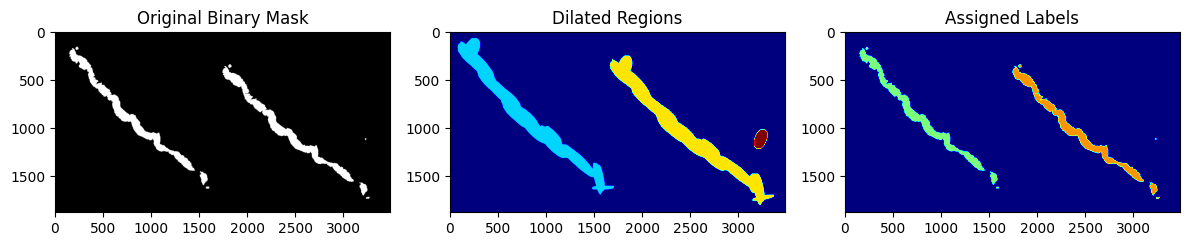

In [6]:
mask_path = filenames[0]
mask = Image.open(mask_path)
b = np.asarray(mask)
b = np.where(b > 0, 1, 0)
dilated_binary_mask = dilate_mask_using_orientation_aware_kernel(b, num_dilations=10)
dilated_labeled_mask = label_binary_mask(dilated_binary_mask)
labeled_mask = assign_labels_using_dilated_mask(b, dilated_labeled_mask)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(b, cmap='gray')
plt.title('Original Binary Mask')
plt.subplot(1, 3, 2)
plt.imshow(dilated_labeled_mask, cmap='jet')
plt.title('Dilated Regions')
plt.subplot(1, 3, 3)
plt.imshow(labeled_mask, cmap='jet')
plt.title('Assigned Labels')
plt.tight_layout()
plt.show()

In [ ]:
np.unique(dilated_labeled_mask)

In [ ]:
np.unique(labeled_mask)

In [ ]:
masks = split_binary_mask(b)
for i, m in enumerate(masks):
    plt.figure()
    plt.imshow(m, cmap='gray')
    plt.title(f'Split Mask {i+1}')
    plt.show()